In [ ]:
# Описание эксперимента:
#
# Перед нами таблица, где числовая переменная – непрерывная. 
# Задача – сравнить группы двумя способами: бутстрапом и u-тестом.
#
# Описание колонок:
#
#    "value" – значения метрики,
#    "experimentVariant" – вариант теста (Control – контроль, Treatment – тест).
#
# Задача:
# 
# 1. Сравните результат между тестом и контролем по двум кейсам:
#    Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value,
#    Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.

In [ ]:
# Импортируем необходимые библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm
import statsmodels.api as sm

plt.style.use('ggplot')
%matplotlib inline

In [96]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
# Визуализация

    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [97]:
# Считываем исходный датафрейм с данными:
# value – значения метрики,
# experimentVariant – вариант теста (Control – контроль, Treatment – тест)

df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';')
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [98]:
# Определим количество строк и столбцов датафрейма

df.shape

(1000, 3)

In [99]:
# Посмотрим на типы данных в датафрейме

df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [100]:
# Изменим тип данных в столбце "value" на вещественный (вместо строкового типа)

df.value = df.value.str.replace(',', '.').astype(float)
df

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [101]:
# Удалим лишний столбец датафрейма - "Unnamed: 0"

df = df.drop(columns=('Unnamed: 0')).rename(columns=({'experimentVariant':'experiment_variant'}))
df

,value,experiment_variant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control
...,...,...
995,1000.000000,Treatment
996,1200.000000,Treatment
997,1500.000000,Treatment
998,2000.000000,Treatment


In [102]:
# Определим количество наблюдений в каждой из выборок - "Control" и "Treatment"

df.experiment_variant.value_counts()

Control      500
Treatment    500
Name: experiment_variant, dtype: int64

In [103]:
# Разделим наш датафрейм на 2 выборки с соответствующими значениями по "Control" и "Treatment"

df_treatment = df.query('experiment_variant == "Treatment"').reset_index().value
df_control = df.query('experiment_variant == "Control"').value

In [104]:
df_treatment

0        10.380495
1         9.546867
2        11.088215
3        10.147274
4         9.789808
          ...     
495    1000.000000
496    1200.000000
497    1500.000000
498    2000.000000
499    3000.000000
Name: value, Length: 500, dtype: float64

In [105]:
df_control

0      10.380495
1       9.546867
2      11.088215
3      10.147274
4       9.789808
         ...    
495    10.973929
496    10.261074
497     8.780090
498    11.169078
499    11.499566
Name: value, Length: 500, dtype: float64

In [106]:
# Выведем таблицу с описательными статистиками по нашим сравниваемым выборкам.
# Здесь нас интересует среднее значение ("mean") и медиана (50% квантиль).
# Видим, что среднее тестовой выборки увеличилось, а медиана почти не изменилась по сравнению с контрольной группой

df_treatment.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

In [107]:
df_control.describe()

count    500.000000
mean      10.026867
std        0.979377
min        6.436541
25%        9.411024
50%       10.018465
75%       10.664879
max       13.130346
Name: value, dtype: float64

In [108]:
# Теперь рассмотрим на выдвижение следующие гипотезы (примем величину "p-value = 0.05"):
# нулевая гипотеза: H0 - средние (медианы) распределений не отличаются,
# альтернативная гипотеза: H1 - средние (медианы) отличаются статистически значимо

In [109]:
# Применим тест Манна-Уитни

mannwhitneyu(df_treatment, df_control)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

In [110]:
# Здесь мы получили "p-value" выше значения "0.05", что не позволяет нам отклонить нулевую гипотезу, 
# что средние двух распределений равны между собой

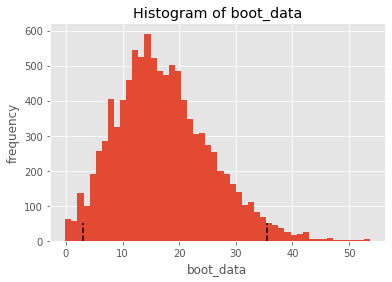

In [111]:
# Применим теперь для тестирования средних Bootstrap метод

booted_data_mean = get_bootstrap(df_treatment, df_control, boot_it = 10000, statistic=np.mean)

In [112]:
booted_data_mean["p_value"]

0.03833380292981082

In [113]:
booted_data_mean["ci"]

,0
0.025,3.048332
0.975,35.499818


In [114]:
# Используя Bootstrap метод для оценивания средних распределений мы видим, что доверительный интервал Bootstrap распределения не 
# пересекает значение "0", при величине "p-value < 0.05". Это значит, что в тесте мы получили статистически значимые отличия среднего 
# и теоретически можем отклонить нулевую гипотезу

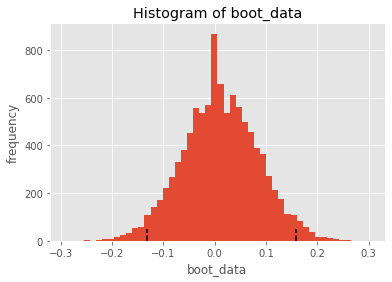

In [115]:
# Применим теперь для тестирования медиан Bootstrap метод

booted_data_median = get_bootstrap(df_treatment, df_control, boot_it = 10000, statistic=np.median)

In [116]:
booted_data_median["p_value"]

0.8761542858258591

In [117]:
booted_data_median["ci"]

,0
0.025,-0.132618
0.975,0.158162


In [118]:
# В данном случае нет статистически значимых различий, что говорит о том, что медианы в тестовой и контрольной группах 
# примерно равны. Также доверительный интервал находится на пересечении "0". Нулевая гипотеза H0 - принимается

In [ ]:
# Выводы:
#
# Проведенный Bootstrap-анализ показывает, что медианы в тестовой и контрольной группах статистически 
# значимо равны: "p-value > 0.05". Также доверительный интервал находится на пересечении "0". 
# Нулевая гипотеза H0 - принимается. Такой же результат был получен с использованием теста Манна-Уитни, и здесь мы также не можем отклонить нулевую гипотезу H0